## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

ModuleNotFoundError: No module named 'torchvision'

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [ ]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [4]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 


### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [5]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def inverse_normalize(tensor):
    # Convert tensor to numpy array
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    tensor = tensor.numpy()
    
    # Inverse normalization
    for i in range(3):  # Loop over each channel
        tensor[i] = (tensor[i] * std[i]) + mean[i]
    tensor = np.clip(tensor, 0, 1)
    
    return tensor


In [6]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/" 
dataset = preprocess_image(dir_path)

torch.Size([3, 224, 224])


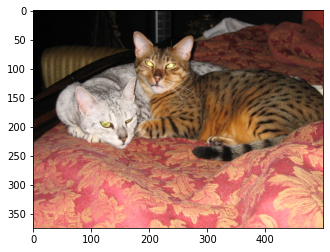

In [7]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

# shape
print(dataset[index][0].shape)



In [8]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))  # the output is a tensor with 1000 elements, each one is the score of a class.there are 1000 classes in the imagenet dataset
values, indices = torch.topk(output, 3) # the top 3 classes ; return a tuple of (values, indices)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy()) 
# print("probability", F.softmax(output, dim=1)[0][indices[0]]) # the probability of the top 3 classes


Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.175316 11.065541 10.584751]


### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + More on [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) and [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [ ]:
class GradCAM:
    def __init__(self, model, conv_layer):
        '''
        Initialize the GradCAM class.
        Input: model (nn.Module), conv_layer (nn.Module)

        '''
        self.model = model # resnet34 model
        self.hook_feature_map = [] # list of feature maps
        self.hook_gradient = [] # list of gradients
        self.conv_layer = conv_layer # resnet34.layer4[-1]
        self.conv_layer.register_forward_hook(self.forward_hook) # capture feature mapas
        self.conv_layer.register_backward_hook(self.backward_hook) # capture gradients

        # put the model in evaluation mode
        self.model.eval()

    def forward_hook(self, model, input, output):
        '''
        Forward hook to capture the feature maps of the last rectified convolutional layer.
        Input: model (nn.Module), input_tensor (tensor), output_tensor (tensor)
        '''
        self.hook_feature_map = output
    
    def backward_hook(self, model, input, output):
        '''
        Backward hook to capture the gradients of the last rectified convolutional layer.
        Input: model (nn.Module), input_tensor (tensor), output_tensor (tensor)
        '''
        self.hook_gradient = output[0] # the gradients are stored in the first element of the output tensor


    def forward_pass(self, image):
        '''
        Forward pass the image in the model and get the top 3 labels with their scores.
        Input: image (tensor)
        Output: output (tensor), values (tensor), indices (tensor)
        '''
        output = self.model(image).squeeze() # 1000 probas
        values, indices = torch.topk(output, k=3) # 3 tuples (13,3, 286)
        last_feature_map = self.hook_feature_map.detach().squeeze()
        return output, values, indices, last_feature_map

    
    def classes_activation_map(self, image):
        '''
        Generate the activation map for the top 3 classes.
        Input: image (tensor)
        Output: heatmaps (dict), indices (tensor), values (tensor)
        '''
        # Forward pass : We make a predicion on the image to retrieve the top 3 classes, their scores and feature maps of the last rectified convolutional layer
        output, values, indices, last_feature_map = self.forward_pass(image)  
        # We initialize the heatmaps dictionary to store the activation maps for the top 3 classes
        heatmaps = [None, None, None]
       # We iterate through the top 3 classes to compute the activation map for each class
        for i, label in enumerate(indices):    
            # We set the gradients of the output layer to zero every time we backpropagate
            self.model.zero_grad() 
            # We encode the label to backpropagate only on the class of interest
            encoded_label = torch.zeros(output.shape[0])
            encoded_label[label] = 1
            output.backward(encoded_label, retain_graph=True)
            # We use the hook_gradient to retrieve the gradients of the last rectified convolutional layer
            gradients = self.hook_gradient.detach().squeeze() 

            # We perform global average pooling on the gradients to get the importance of each feature map
            feature_pooling = F.adaptive_avg_pool2d(gradients, (1, 1)).squeeze()
            
            # We compute the weighted feature map by multiplying the importance of each feature map by the feature map itself
            Weighted_feature_map = torch.sum(
                feature_pooling.view(-1, 1, 1) * last_feature_map, dim=0
            )
            # dim 0 for summing the elements along the first dimension. 
            # This means tat it's adding together the values of all feature maps at each (x, y)  pixel
            # We apply the ReLU activation function to the weighted feature map to get the activation map
            relu = torch.nn.ReLU()
            relu_heatmap = relu(Weighted_feature_map) # 1(channel) x 7x7  # Relu is used to remove the negative values
            # project the heatmap to the original image size to visualize it better
            heatmaps[i] = nn.functional.interpolate(relu_heatmap.unsqueeze(0).unsqueeze(0),(224,224),mode='bilinear').squeeze() # unsqueee to make it 1x1x7x7 
 
        return heatmaps, indices, values,relu_heatmap
    
    

    def plot_activation_maps(self, dataset):
        '''
        Plot the original images with their activation maps and the top 3 classes.
        Input: dataset (torch.utils.data.Dataset)
        '''
        n_images = len(dataset)
        fig, ax = plt.subplots(n_images, 4, figsize=(20, 100))
        for i in range(n_images):
            image = dataset[i][0].view(1, 3, 224, 224)
            original_image = dataset[i][0]  # Original image without view()
            original_image_denormalize = inverse_normalize(original_image).transpose(1, 2, 0)

            heatmaps, indices, values, relu_heatmap = self.classes_activation_map(image)
            for j in range(4):  # 4 columns
                if j == 3:  
                    ax[i, j].imshow(original_image_denormalize)
                    ax[i, j].imshow(relu_heatmap, cmap='rainbow')
                    ax[i, j].set_title("")
                else:
                    ax[i, j].imshow(original_image_denormalize)
                    ax[i, j].imshow(heatmaps[j], cmap='rainbow', alpha=0.45)
                    title_label = " \n Top {} class : {} \n".format(j+1, classes[int(indices[j])])
                    title_score = "Score: {}".format(values[j])
                    ax[i, j].set_title(title_label + title_score)
        plt.show()
        

grad_CAM = GradCAM(resnet34, resnet34.layer4[2].conv2)
grad_CAM.plot_activation_maps(dataset)

In [ ]:
grad_CAM = GradCAM(resnet34, resnet34.layer4[-1])
grad_CAM.plot_activation_maps(dataset)

### Complementary questions:

##### Try GradCAM on others convolutional layers, describe and comment the results

In [ ]:
grad_CAM = GradCAM(resnet34, resnet34.layer2[2])
grad_CAM.plot_activation_maps(dataset)

En changeant les couches qu'on utilise pour le GradCAM on retrouve différente carte d'attention. Les layers plutot supperficiel capture des élements précis de l'image tandis que les couches plus profonde, comme par exemple resnet34.layer4[-1]  On retrouve des changement 

L'utilisation de Grad-CAM avec des couches plus profondes d'un réseau de neurones, comme dans notre exemple avec resnet34.layer4[2], tend à produire des cartes d'activation qui capturent des caractéristiques plus généralisées de l'image. A mesure que nous progressons vers les couches plus profondes du réseau, les caractéristiques extraites se détachent des détails spécifiques pour embrasser des motifs plus globaux qui représentent des concepts de plus haut niveau.

##### What are the principal contributions of GradCAM (the answer is in the paper) ?

**1- Broad Applicability**: Works with various CNN architectures without model-specific modifications, enhancing its versatility across different tasks.

**2- Class-discriminative Localization**: Highlights image regions important for model decisions, aiding in understanding and diagnosing model behavior.

**3- Enhanced Interpretability**: Offers visual explanations that improve the interpretability of deep learning models, crucial for sensitive applications.

**4- Combinable with Other Techniques**: Can be combined with techniques like Guided Backpropagation for even more detailed visual explanations.

**5- Ease of Implementation and Use**: Accessible and straightforward to implement, facilitating wider adoption without extensive computational demands.

**6- Building Trust and Debugging**: Helps in building trust in AI systems and assists in debugging by visually indicating model focus areas. 